In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
from os.path import exists

print(f' ------------- \n',
      f'Versions: \n',
      f'------------- \n'
      f' numpy=={np.__version__} \n'
     )

 ------------- 
 Versions: 
 ------------- 
 numpy==1.22.1 



## Reference Values:

In [2]:
h_ref = 1e-2
rho_ref = 5e3
lambda_ref = 2.5e3**2*rho_ref
c_ref = np.sqrt(lambda_ref/rho_ref)

## Material Properties

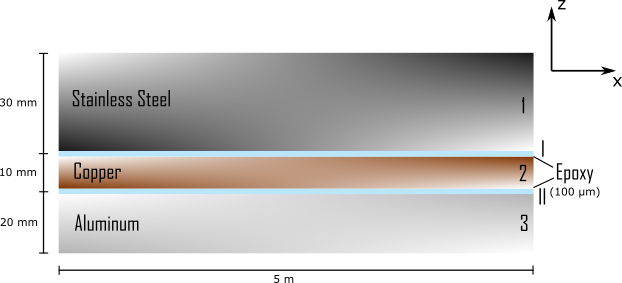

> Importing mode parameters:

In [3]:
def load_mode_parameters(interface_of_interest, direction_of_interest):
    with open(f'./results/modes_parameters/kx_{interface_of_interest}_{direction_of_interest}', 'rb') as fp:
        kx_mode = pickle.load(fp)
    with open(f'./results/modes_parameters/freq_{interface_of_interest}_{direction_of_interest}', 'rb') as fp:
        freq_mode = 1000*pickle.load(fp)
    with open(f'./results/modes_parameters/deltaU_{interface_of_interest}_{direction_of_interest}', 'rb') as fp:
        deltaU = pickle.load(fp)
    with open(f'./results/modes_parameters/u_1_spec_{interface_of_interest}_{direction_of_interest}', 'rb') as fp:
        u_1_spec = pickle.load(fp)
    with open(f'./results/modes_parameters/u_2_spec_{interface_of_interest}_{direction_of_interest}', 'rb') as fp:
        u_2_spec = pickle.load(fp)
    with open(f'./results/modes_parameters/x_{interface_of_interest}_{direction_of_interest}', 'rb') as fp:
        x = pickle.load(fp)
    with open(f'./results/modes_parameters/kx_vec_{interface_of_interest}_{direction_of_interest}', 'rb') as fp:
        kx_vec = pickle.load(fp)
        
    return kx_mode, freq_mode, deltaU, u_1_spec, u_2_spec, x, kx_vec

- ### Layer 1 (Aluminum):

In [4]:
rho_1 = 2700/rho_ref
vp_1 = 6320/c_ref
vs_1 = 3130/c_ref
mu_1 = vs_1**2*rho_1
lambda_1 = vp_1**2*rho_1-2*mu_1
h_1 = 2e-2/h_ref

- ### Layer 2 (Copper):

In [5]:
rho_2 = 8930/rho_ref
vp_2 = 4660/c_ref
vs_2 = 2660/c_ref
mu_2 = vs_2**2*rho_2
lambda_2 = vp_2**2*rho_2-2*mu_2
h_2 = 1e-2/h_ref

- ### Layer 3 (Stainless Steel):

In [6]:
rho_3 = 7900/rho_ref
vp_3 = 5790/c_ref
vs_3 = 3100/c_ref
mu_3 = vs_3**2*rho_3
lambda_3 = vp_3**2*rho_3-2*mu_3
h_3 = 3e-2/h_ref

- ### Interfaces:

> ##### Interface II (Layers 1-2)

In [7]:
h_interface_2 = 100e-6/h_ref
vp_interface_2 = 2150/c_ref
vs_interface_2 = 1030/c_ref
rho_interface_2 = 1200/rho_ref

> ##### Interface III (Layers 2-3)

In [8]:
h_interface_3 = 100e-6/h_ref
vp_interface_3 = 2150/c_ref
vs_interface_3 = 1030/c_ref
rho_interface_3 = 1200/rho_ref

> ##### Computing stiffness (QSA):

In [9]:
def computeSpecularStiffness(thickness, rho, P_speed, S_speed):
    mu = (S_speed**2)*rho
    lamb = (P_speed**2)*rho-2*mu
    s = 1/mu
    c = 2*mu+lamb
    K_specular = np.linalg.inv(thickness*np.array([[s, 0, 0], [0, s, 0], [0, 0, 1/c]]))
    return K_specular

########################################################################################

def computeScatteredStiffness(
    Kspec_2,
    Kspec_3,
    damage,
    interface_of_interest,
    direction_of_interest
):
        Kspec = [Kspec_2, Kspec_3]
        nx = damage.shape[0]
        Kscat_2 = np.zeros((3, 3, nx))
        Kscat_3 = np.zeros((3, 3, nx))
        Kscat = [Kscat_2, Kscat_3]
        Kscat[interfaces_dict[interface_of_interest]][
            defect_dict[direction_of_interest],
            defect_dict[direction_of_interest],
            :
        ] = Kspec[interfaces_dict[interface_of_interest]][
            defect_dict[direction_of_interest],
            defect_dict[direction_of_interest]
        ]*damage.reshape(nx,) - Kspec[interfaces_dict[interface_of_interest]][
            defect_dict[direction_of_interest],
            defect_dict[direction_of_interest]
        ]
        return Kscat[0], Kscat[1]

> ##### Generating Defects:

In [10]:
defect_dict = {'xx': 0, 'yy': 1, 'zz': 2}
interfaces_dict = {
    'aluminum-copper':0,
    'copper-stainless steel':1 
    }

def randomFieldDefect(
    x,
    correlation_length,
    stdev,
    number_of_samples,
    mean_random_field=0,
    field_type = 'gaussian'
):

    n_elements = len(x)
    if field_type == 'gaussian':
        covariance_field = lambda r, s :stdev ** 2 * np.exp(-1 * ((r - s) / correlation_length) ** 2)
    elif field_type == 'exponential':
        covariance_field = lambda r, s : stdev ** 2 * np.exp(-1 * abs(r - s) / correlation_length)
    else:
        return print('error - field type not found')
    covariance_matrix = np.zeros((n_elements, n_elements))
    for ii in range(0, n_elements):
        for jj in range(ii, n_elements):
            covariance_matrix[ii, jj] = covariance_field(x[ii], x[jj])
    covariance_matrix = (covariance_matrix + covariance_matrix.T) - np.diag(np.diag(covariance_matrix))
    xi = np.random.randn(n_elements, number_of_samples)
    muY = mean_random_field * np.ones((n_elements, number_of_samples))
    Ag, Ug = np.linalg.eig(covariance_matrix)
    Ag = np.diag(Ag)
    Vg = np.dot(Ug, np.real(np.sqrt(Ag, dtype = complex)))
    random_field = muY + np.dot(Vg, xi)
    random_field_transformed = np.tanh(np.exp(-random_field))
    for ii in range(0, number_of_samples):
        random_field_transformed[:, ii] = (random_field_transformed[:, ii] - max(random_field_transformed[:, ii]))
    # filter to avoid having defects at the edges:
    filter_center = (x[0] + x[-1])/2
    filter_sigma = x[-1]/24
    filter_offset = x[-1] - x[-1]/6.5*(x[-1] - x[0])
    field_filter = np.zeros(x.shape)
    
    random_field_filtered = np.zeros(random_field.shape)
    for ii in range(0, len(x)):
        field_filter[ii] = np.exp(- np.max([0, abs(x[ii] - filter_center) - filter_offset]) / (2 * filter_sigma ** 2))
    damage_field = np.zeros(random_field.shape)
    damage_field_transformed = np.zeros(random_field.shape)
    for ii in range(len(x)):
        damage_field_transformed[ii, :] = field_filter[ii] * random_field_transformed[ii, :] + 1
        random_field_filtered[ii, :] = field_filter[ii] * random_field[ii, :]
        
    return random_field, damage_field_transformed, covariance_matrix

- ### Computing acoustic tensors:

In [11]:
def computePropagationMatrices(kx, kp, kt, h_up, h_down):
    
    kp_z = np.sqrt(kp**2-kx**2, dtype=complex)
    kt_z = np.sqrt(kt**2-kx**2, dtype=complex)
    
    gamma_up = np.zeros((3, 3), dtype=complex)
    np.fill_diagonal(
        gamma_up,
        [np.exp(1j*kp_z*h_up),
         np.exp(1j*kt_z*h_up),
         np.exp(1j*kt_z*h_up)]
    )
    gamma_down = np.zeros((3, 3), dtype=complex)
    np.fill_diagonal(
        gamma_down,
        [np.exp(-1j*kp_z*h_down),
         np.exp(-1j*kt_z*h_down),
         np.exp(-1j*kt_z*h_down)]
    )

    A_up = np.array(
        [[kx/kp, -kt_z/kt, 0],
         [0, 0, 1],
         [kp_z/kp, kx/kt, 0]]
    )
    A_down = np.array(
        [[kx/kp, kt_z/kt, 0],
         [0, 0, 1],
         [-kp_z/kp, kx/kt, 0]]
    )

    M_up = np.dot(np.dot(A_up, gamma_up), np.linalg.inv(A_up))
    M_down = np.dot(np.dot(A_down, gamma_down), np.linalg.inv(A_down))

    return M_up, M_down


########################################################################################


def computeImpedances(omega, kx, kp, kt, lambda_, mu):

    kp_z = np.sqrt(kp**2-kx**2, dtype=complex)
    kt_z = np.sqrt(kt**2-kx**2, dtype=complex)

    A_aux_up = np.array([[kx, kp_z], [kt_z, -kx]], dtype=complex)
    A_aux_down = np.array([[-kx, kp_z], [kt_z, kx]], dtype=complex)

    C1_up = np.array(
        [[-2*mu*kp_z*kx/omega], [(mu/omega)*(kx**2-kt_z**2)]],
        dtype = complex
    )
    C2_up = np.array(
        [[-(lambda_*kp**2+2*mu*kp_z**2)/omega], [2*mu*kt_z*kx/omega]],
        dtype=complex
    )
    C1_down = np.array(
        [[-2*mu*kp_z*kx/omega], [-(mu/omega)*(kx**2-kt_z**2)]],
        dtype=complex
    )
    C2_down = np.array(
        [[(lambda_*kp**2+2*mu*kp_z**2)/omega], [2*mu*kt_z*kx/omega]],
        dtype=complex
    )

    z_11_up_z_13_up = np.dot(np.linalg.inv(A_aux_up), C1_up)
    z_11_up = z_11_up_z_13_up[0]
    z_13_up = z_11_up_z_13_up[1]
    z_12_up = 0
    z_21_up = 0
    z_22_up = -mu*kt_z/omega
    z_23_up = 0
    z_32_up = 0
    z_31_up_z_33_up = np.dot(np.linalg.inv(A_aux_up), C2_up)
    z_31_up = z_31_up_z_33_up[0]
    z_33_up = z_31_up_z_33_up[1]

    z_11_down_z_13_down = np.dot(np.linalg.inv(A_aux_down), C1_down)
    z_11_down = z_11_down_z_13_down[0]
    z_13_down = z_11_down_z_13_down[1]
    z_12_down = 0
    z_21_down = 0
    z_22_down = mu*kt_z/omega
    z_23_down = 0
    z_32_down = 0
    z_31_down_z_33_down = np.dot(np.linalg.inv(A_aux_down), C2_down)
    z_31_down = z_31_down_z_33_down[0]
    z_33_down = z_31_down_z_33_down[1]

    Z_up = np.array(
        [[z_11_up, z_12_up, z_13_up],
         [z_21_up, z_22_up, z_23_up],
         [z_31_up, z_32_up, z_33_up]],
        dtype=complex
    )

    Z_down = np.array(
        [[z_11_down, z_12_down, z_13_down],
         [z_21_down, z_22_down, z_23_down],
         [z_31_down, z_32_down, z_33_down]],
        dtype=complex
    )

    return Z_up, Z_down

- ## Saving Parameters:

In [12]:
def saveDynamicParameters(
    interface_of_interest,
    direction_of_interest,
    sample_log,
    damage,
    random_field,
    u_solution,
    cost_function_0,
    cost_function_final
):
    with open(f'./data/{interface_of_interest}_{direction_of_interest}/damages/damage_{sample_log}', 'wb') as fp:
        pickle.dump(damage, fp)
    with open(f'./data/{interface_of_interest}_{direction_of_interest}/random_fields/random_field_{sample_log}', 'wb') as fp:
        pickle.dump(random_field, fp)
    with open(f'./data/{interface_of_interest}_{direction_of_interest}/scattered_fields/u_scatt_{sample_log}', 'wb') as fp:
        pickle.dump(u_solution, fp)
    with open(f'./data/{interface_of_interest}_{direction_of_interest}/residuals/initial_residual_{sample_log}', 'wb') as fp:
        pickle.dump(cost_function_0, fp)
    with open(f'./data/{interface_of_interest}_{direction_of_interest}/residuals/final_residual_{sample_log}', 'wb') as fp:
        pickle.dump(cost_function_final, fp)
        
def saveStaticParameters(interface_of_interest, direction_of_interest, u_spec, cov_matrix):
    with open(f'./data/{interface_of_interest}_{direction_of_interest}/u_spec', 'wb') as fp:
        pickle.dump(u_spec, fp)
    with open(f'./data/{interface_of_interest}_{direction_of_interest}/cov_matrix', 'wb') as fp:
        pickle.dump(cov_matrix, fp)
        
def saveSampleLog(interface_of_interest, direction_of_interest, sample_log):
    with open(f'./data/{interface_of_interest}_{direction_of_interest}/sample_log', 'wb') as fp:
        pickle.dump(sample_log, fp)

def loadSampleLog(interface_of_interest, direction_of_interest):
    with open(f'./data/{interface_of_interest}_{direction_of_interest}/sample_log', 'rb') as fp:
        sample_log = pickle.load(fp)
    return sample_log

- ## Solving Acoustic Scattering Problem:

In [18]:
def solveAcousticScatteringProblem(
    interface_of_interest,
    direction_of_interest,
    n_samples
):
    if exists(f'./data/{interface_of_interest}_{direction_of_interest}/sample_log'):
        sample_log = loadSampleLog(interface_of_interest, direction_of_interest)
    else:
        sample_log = 0
    kx_mode, freq_mode, deltaU, u_1_spec, u_2_spec, x, kx = load_mode_parameters(
        interface_of_interest,
        direction_of_interest
    )
    nkx = len(kx)
    omega = freq_mode*2*np.pi*h_ref/c_ref
    x_dimensionless = x/h_ref
    nx = len(x)
    u_spec = u_1_spec + u_2_spec
    if exists(f'./data/{interface_of_interest}_{direction_of_interest}/u_spec') == False:
        _, _, cov_matrix = randomFieldDefect(
            x,
            correlation_length=0.56, # 0.2
            stdev=0.8,
            number_of_samples=1,
            mean_random_field=0,
            field_type = 'gaussian'
        )
        saveStaticParameters(interface_of_interest, direction_of_interest, u_spec, cov_matrix)

    # Layer 1:

    Z_up_1 = np.zeros((3, 3, nkx), dtype = complex)
    Z_down_1 = np.zeros((3, 3, nkx), dtype = complex)
    M_up_1 = np.zeros((3, 3, nkx), dtype = complex)
    M_down_1 = np.zeros((3, 3, nkx), dtype = complex)
    kp_1 = omega/vp_1
    kt_1 = omega/vs_1

    # Layer 2:

    Z_up_2 = np.zeros((3, 3, nkx), dtype = complex)
    Z_down_2 = np.zeros((3, 3, nkx), dtype = complex)
    M_up_2 = np.zeros((3, 3, nkx), dtype = complex)
    M_down_2 = np.zeros((3, 3, nkx), dtype = complex)
    kp_2 = omega/vp_2
    kt_2 = omega/vs_2

    # Layer 3:

    Z_up_3 = np.zeros((3, 3, nkx), dtype = complex)
    Z_down_3 = np.zeros((3, 3, nkx), dtype = complex)
    M_up_3 = np.zeros((3, 3, nkx), dtype = complex)
    M_down_3 = np.zeros((3, 3, nkx), dtype = complex)
    kp_3 = omega/vp_3
    kt_3 = omega/vs_3

    for ii in range(nkx):

        Z_up_1[:, :, ii], Z_down_1[:, :, ii] = computeImpedances(omega, kx[ii], kp_1, kt_1, lambda_1, mu_1)
        M_up_1[:, :, ii], M_down_1[:, :, ii] = computePropagationMatrices(kx[ii], kp_1, kt_1, -h_1, -h_1)

        Z_up_2[:, :, ii], Z_down_2[:, :, ii] = computeImpedances(omega, kx[ii], kp_2, kt_2, lambda_2, mu_2)
        M_up_2[:, :, ii], M_down_2[:, :, ii] = computePropagationMatrices(kx[ii], kp_2, kt_2, -h_2, -h_2)

        Z_up_3[:, :, ii], Z_down_3[:, :, ii] = computeImpedances(omega, kx[ii], kp_3, kt_3, lambda_3, mu_3)
        M_up_3[:, :, ii], M_down_3[:, :, ii] = computePropagationMatrices(kx[ii], kp_3, kt_3, -h_3, -h_3)

    Kspec_2 = computeSpecularStiffness(h_interface_2, rho_interface_2, vp_interface_2, vs_interface_2)
    Kspec_3 = computeSpecularStiffness(h_interface_3, rho_interface_3, vp_interface_3, vs_interface_3)
    deltaU_list = [np.zeros(deltaU.shape), np.zeros(deltaU.shape)]
    deltaU_list[interfaces_dict[interface_of_interest]] = deltaU
    deltaU_2 = deltaU_list[0]
    deltaU_3 = deltaU_list[1]
    
    for sample in range(n_samples):
        sample_log += 1
        random_field, damage, cov_matrix = randomFieldDefect(
            x,
            correlation_length=0.1, # 0.56
            stdev=0.8,
            number_of_samples=1,
            mean_random_field=0,
            field_type = 'gaussian'
        )
        damage = damage.reshape((damage.shape[0],))
        Kscat_2, Kscat_3 = computeScatteredStiffness(
            Kspec_2,
            Kspec_3,
            damage,
            interface_of_interest,
            direction_of_interest
        )
        
        p0_guess_fft = np.zeros((1, 4 * nkx), dtype = complex)
        u_guess_fft = np.zeros((3, nkx), dtype = complex)
        count = 0

        for ii in range(0, len(p0_guess_fft[0,:]), 4):
            u_guess_fft[0, count] = p0_guess_fft[0, ii] + p0_guess_fft[0, ii + 1] * 1j
            u_guess_fft[1, count] = 0
            u_guess_fft[2, count] = p0_guess_fft[0, ii + 2] + p0_guess_fft[0, ii + 3] * 1j
            count += 1
        u_up_top_3_fft = u_guess_fft
        
        u_down_top_3_fft = np.zeros(u_up_top_3_fft.shape, dtype = complex)
        for ii in range(nkx):
            u_down_top_3_fft[:, ii] = -np.dot(
                np.dot(np.linalg.inv(Z_down_3[:, :, ii]), Z_up_3[:, :, ii]),
                u_up_top_3_fft[:, ii]
            )
        u_down_bottom_3_fft = np.zeros(u_up_top_3_fft.shape, dtype = complex)
        u_up_bottom_3_fft = np.zeros(u_up_top_3_fft.shape, dtype = complex)
        for ii in range(nkx):
            u_up_bottom_3_fft[:, ii] = np.dot(M_up_3[: ,:, ii], u_up_top_3_fft[:, ii])
            u_down_bottom_3_fft[:, ii] = np.dot(M_down_3[: ,:, ii], u_down_top_3_fft[:, ii])
        u_bottom_3_fft = u_up_bottom_3_fft + u_down_bottom_3_fft
        t_bottom_3_fft = np.zeros(u_up_top_3_fft.shape, dtype = complex)

        for ii in range(nkx):
            t_bottom_3_fft[:, ii] = -1j*omega*(
                np.dot(Z_up_3[:, :, ii], u_up_bottom_3_fft[:, ii])+np.dot(Z_down_3[:, :, ii], u_down_bottom_3_fft[:, ii])
            )

        u_bottom_3 = np.array(
            [np.fft.ifft(np.fft.ifftshift(u_bottom_3_fft[dim, :])) for dim in range(u_bottom_3_fft.shape[0])]
        )
        t_bottom_3 = np.array(
            [np.fft.ifft(np.fft.ifftshift(t_bottom_3_fft[dim, :])) for dim in range(t_bottom_3_fft.shape[0])]
        )
        K_3 = np.zeros((3, 3, nx))
        for ii in range(K_3.shape[0]):
            K_3[ii, ii, :] = Kspec_3[ii, ii] + Kscat_3[ii, ii, :]
        u_top_2 = np.zeros(u_up_top_3_fft.shape, dtype = complex)

        for ii in range(nkx):
            u_top_2[:, ii] = np.dot(
                np.linalg.inv(K_3[:, :, ii]),
                (np.dot(Kscat_3[:, :, ii], deltaU_3[:, ii]) - t_bottom_3[:, ii])
            ) + u_bottom_3[:, ii]

        u_top_2_fft = np.array(
            [np.fft.fftshift(np.fft.fft(u_top_2[dim, :])) for dim in range(u_top_2.shape[0])], dtype = complex
        )
        u_up_top_2_fft = np.zeros(u_up_top_3_fft.shape, dtype = complex)
        u_down_top_2_fft = np.zeros(u_up_top_3_fft.shape, dtype = complex)

        for ii in range(nkx):
            u_up_top_2_fft[:, ii] = -np.dot(
                np.linalg.inv(Z_up_2[:, :, ii]-Z_down_2[:, :, ii]),
                (t_bottom_3_fft[:, ii]/(1j*omega)-np.dot(Z_down_2[:, :, ii], u_top_2_fft[:, ii]))

            )
            u_down_top_2_fft[:, ii] = u_top_2_fft[:, ii] - u_up_top_2_fft[:, ii]
        u_down_bottom_2_fft = np.zeros(u_up_top_3_fft.shape, dtype = complex)
        u_up_bottom_2_fft = np.zeros(u_up_top_3_fft.shape, dtype = complex)
        for ii in range(nkx):
            u_up_bottom_2_fft[:, ii] = np.dot(M_up_2[: ,:, ii], u_up_top_2_fft[:, ii])
            u_down_bottom_2_fft[:, ii] = np.dot(M_down_2[: ,:, ii], u_down_top_2_fft[:, ii])
        u_bottom_2_fft = u_up_bottom_2_fft + u_down_bottom_2_fft
        t_bottom_2_fft = np.zeros(u_up_top_3_fft.shape, dtype = complex)

        for ii in range(nkx):
            t_bottom_2_fft[:, ii] = -1j*omega*(
                np.dot(Z_up_2[:, :, ii], u_up_bottom_2_fft[:, ii])+np.dot(Z_down_2[:, :, ii], u_down_bottom_2_fft[:, ii])
            )

        u_bottom_2 = np.array(
            [np.fft.ifft(np.fft.ifftshift(u_bottom_2_fft[dim, :])) for dim in range(u_bottom_2_fft.shape[0])]
        )
        t_bottom_2 = np.array(
            [np.fft.ifft(np.fft.ifftshift(t_bottom_2_fft[dim, :])) for dim in range(t_bottom_2_fft.shape[0])]
        )
        K_2 = np.zeros((3, 3, nx))
        for ii in range(K_3.shape[0]):
            K_2[ii, ii, :] = Kspec_2[ii, ii] + Kscat_2[ii, ii, :]
        u_top_1 = np.zeros(u_up_top_3_fft.shape, dtype = complex)

        for ii in range(nkx):
            u_top_1[:, ii] = np.dot(
                np.linalg.inv(K_2[:, :, ii]),
                (np.dot(Kscat_2[:, :, ii], deltaU_2[:, ii]) - t_bottom_2[:, ii])
            ) + u_bottom_2[:, ii]

        u_top_1_fft = np.array(
            [np.fft.fftshift(np.fft.fft(u_top_1[dim, :])) for dim in range(u_top_1.shape[0])], dtype = complex
        )
        u_up_top_1_fft = np.zeros(u_up_top_3_fft.shape, dtype = complex)
        u_down_top_1_fft = np.zeros(u_up_top_3_fft.shape, dtype = complex)

        for ii in range(nkx):
            u_up_top_1_fft[:, ii] = -np.dot(
                np.linalg.inv(Z_up_1[:, :, ii]-Z_down_1[:, :, ii]),
                (t_bottom_2_fft[:, ii]/(1j*omega)-np.dot(Z_down_1[:, :, ii], u_top_1_fft[:, ii]))

            )
            u_down_top_1_fft[:, ii] = u_top_1_fft[:, ii] - u_up_top_1_fft[:, ii]
        u_down_bottom_1_fft = np.zeros(u_up_top_3_fft.shape, dtype = complex)
        u_up_bottom_1_fft = np.zeros(u_up_top_3_fft.shape, dtype = complex)
        for ii in range(nkx):
            u_up_bottom_1_fft[:, ii] = np.dot(M_up_1[: ,:, ii], u_up_top_1_fft[:, ii])
            u_down_bottom_1_fft[:, ii] = np.dot(M_down_1[: ,:, ii], u_down_top_1_fft[:, ii])
        t_bottom_1_fft = np.zeros(u_up_top_3_fft.shape, dtype = complex)

        for ii in range(nkx):
            t_bottom_1_fft[:, ii] = -1j*omega*(
                np.dot(Z_up_1[:, :, ii], u_up_bottom_1_fft[:, ii])+np.dot(Z_down_1[:, :, ii], u_down_bottom_1_fft[:, ii])
            )
        residual_vector = np.zeros((4*nkx, 1), dtype = complex)
        residual_aux1 = t_bottom_1_fft[0, :]
        residual_aux3 = t_bottom_1_fft[2, :]
        count = 0

        for ii in range(0, nkx):

            residual_vector[count, 0] = np.real(residual_aux1[ii])
            residual_vector[count+1, 0] = np.real(residual_aux3[ii])
            residual_vector[count+2, 0] = np.imag(residual_aux1[ii])
            residual_vector[count+3, 0] = np.imag(residual_aux3[ii])
            count += 4

        cost_function_0 = np.dot(residual_vector.T, residual_vector)
        jacobian_matrix = np.zeros((4*nkx, 4*nkx), dtype=complex)
        epsilon = 1.0

        for kk in range(0, 4*nkx):

            p_fft = np.zeros((1, 4*nkx), dtype=complex)
            p_fft[0, kk] = p_fft[0, kk]+epsilon
            u_iter_fft = np.zeros((3, nkx), dtype=complex)
            count = 0
            for ii in range(0, len(p0_guess_fft[0,:]), 4):
                u_iter_fft[0, count] = p_fft[0, ii]+p_fft[0, ii+1]*1j
                u_iter_fft[1, count] = 0
                u_iter_fft[2, count] = p_fft[0, ii+2]+p_fft[0, ii+3]*1j
                count += 1
            u_up_top_3_fft = u_iter_fft

            u_down_top_3_fft = np.zeros(u_up_top_3_fft.shape, dtype = complex)
            for ii in range(nkx):
                u_down_top_3_fft[:, ii] = -np.dot(np.dot(np.linalg.inv(Z_down_3[:, :, ii]), Z_up_3[:, :, ii]), u_up_top_3_fft[:, ii])

            u_down_bottom_3_fft = np.zeros(u_up_top_3_fft.shape, dtype = complex)
            u_up_bottom_3_fft = np.zeros(u_up_top_3_fft.shape, dtype = complex)
            for ii in range(nkx):
                u_up_bottom_3_fft[:, ii] = np.dot(M_up_3[: ,:, ii], u_up_top_3_fft[:, ii])
                u_down_bottom_3_fft[:, ii] = np.dot(M_down_3[: ,:, ii], u_down_top_3_fft[:, ii])

            u_bottom_3_fft = u_up_bottom_3_fft + u_down_bottom_3_fft
            t_bottom_3_fft = np.zeros(u_up_top_3_fft.shape, dtype = complex)
            for ii in range(nkx):
                t_bottom_3_fft[:, ii] = -1j*omega*(
                    np.dot(Z_up_3[:, :, ii], u_up_bottom_3_fft[:, ii])+np.dot(Z_down_3[:, :, ii], u_down_bottom_3_fft[:, ii])
                )

            u_bottom_3 = np.array(
                [np.fft.ifft(np.fft.ifftshift(u_bottom_3_fft[dim, :])) for dim in range(u_bottom_3_fft.shape[0])]
            )
            t_bottom_3 = np.array(
                [np.fft.ifft(np.fft.ifftshift(t_bottom_3_fft[dim, :])) for dim in range(t_bottom_3_fft.shape[0])]
            )

            K_3 = np.zeros((3, 3, nx))
            for ii in range(K_3.shape[0]):
                K_3[ii, ii, :] = Kspec_3[ii, ii] + Kscat_3[ii, ii, :]
            u_top_2 = np.zeros(u_up_top_3_fft.shape, dtype = complex)

            for ii in range(nkx):
                u_top_2[:, ii] = np.dot(
                    np.linalg.inv(K_3[:, :, ii]),
                    (np.dot(Kscat_3[:, :, ii], deltaU_3[:, ii]) - t_bottom_3[:, ii])
                ) + u_bottom_3[:, ii]

            u_top_2_fft = np.array(
                [np.fft.fftshift(np.fft.fft(u_top_2[dim, :])) for dim in range(u_top_2.shape[0])], dtype = complex
            )

            u_up_top_2_fft = np.zeros(u_up_top_3_fft.shape, dtype = complex)
            u_down_top_2_fft = np.zeros(u_up_top_3_fft.shape, dtype = complex)

            for ii in range(nkx):
                u_up_top_2_fft[:, ii] = -np.dot(
                    np.linalg.inv(Z_up_2[:, :, ii]-Z_down_2[:, :, ii]),
                    (t_bottom_3_fft[:, ii]/(1j*omega)-np.dot(Z_down_2[:, :, ii], u_top_2_fft[:, ii]))

                )
                u_down_top_2_fft[:, ii] = u_top_2_fft[:, ii] - u_up_top_2_fft[:, ii]

            u_down_bottom_2_fft = np.zeros(u_up_top_3_fft.shape, dtype = complex)
            u_up_bottom_2_fft = np.zeros(u_up_top_3_fft.shape, dtype = complex)
            for ii in range(nkx):
                u_up_bottom_2_fft[:, ii] = np.dot(M_up_2[: ,:, ii], u_up_top_2_fft[:, ii])
                u_down_bottom_2_fft[:, ii] = np.dot(M_down_2[: ,:, ii], u_down_top_2_fft[:, ii])

            u_bottom_2_fft = u_up_bottom_2_fft + u_down_bottom_2_fft
            t_bottom_2_fft = np.zeros(u_up_top_3_fft.shape, dtype = complex)

            for ii in range(nkx):
                t_bottom_2_fft[:, ii] = -1j*omega*(
                    np.dot(Z_up_2[:, :, ii], u_up_bottom_2_fft[:, ii])+np.dot(Z_down_2[:, :, ii], u_down_bottom_2_fft[:, ii])
                )

            u_bottom_2 = np.array(
                [np.fft.ifft(np.fft.ifftshift(u_bottom_2_fft[dim, :])) for dim in range(u_bottom_2_fft.shape[0])]
            )
            t_bottom_2 = np.array(
                [np.fft.ifft(np.fft.ifftshift(t_bottom_2_fft[dim, :])) for dim in range(t_bottom_2_fft.shape[0])]
            )

            K_2 = np.zeros((3, 3, nx))
            for ii in range(K_3.shape[0]):
                K_2[ii, ii, :] = Kspec_2[ii, ii] + Kscat_2[ii, ii, :]
            u_top_1 = np.zeros(u_up_top_3_fft.shape, dtype = complex)

            for ii in range(nkx):
                u_top_1[:, ii] = np.dot(
                    np.linalg.inv(K_2[:, :, ii]),
                    (np.dot(Kscat_2[:, :, ii], deltaU_2[:, ii]) - t_bottom_2[:, ii])
                ) + u_bottom_2[:, ii]

            u_top_1_fft = np.array(
                [np.fft.fftshift(np.fft.fft(u_top_1[dim, :])) for dim in range(u_top_1.shape[0])], dtype = complex
            )

            u_up_top_1_fft = np.zeros(u_up_top_3_fft.shape, dtype = complex)
            u_down_top_1_fft = np.zeros(u_up_top_3_fft.shape, dtype = complex)

            for ii in range(nkx):
                u_up_top_1_fft[:, ii] = -np.dot(
                    np.linalg.inv(Z_up_1[:, :, ii]-Z_down_1[:, :, ii]),
                    (t_bottom_2_fft[:, ii]/(1j*omega)-np.dot(Z_down_1[:, :, ii], u_top_1_fft[:, ii]))

                )
                u_down_top_1_fft[:, ii] = u_top_1_fft[:, ii] - u_up_top_1_fft[:, ii]

            u_down_bottom_1_fft = np.zeros(u_up_top_3_fft.shape, dtype = complex)
            u_up_bottom_1_fft = np.zeros(u_up_top_3_fft.shape, dtype = complex)
            for ii in range(nkx):
                u_up_bottom_1_fft[:, ii] = np.dot(M_up_1[: ,:, ii], u_up_top_1_fft[:, ii])
                u_down_bottom_1_fft[:, ii] = np.dot(M_down_1[: ,:, ii], u_down_top_1_fft[:, ii])

            t_bottom_1_fft = np.zeros(u_up_top_3_fft.shape, dtype = complex)

            for ii in range(nkx):
                t_bottom_1_fft[:, ii] = -1j*omega*(
                    np.dot(Z_up_1[:, :, ii], u_up_bottom_1_fft[:, ii])+np.dot(Z_down_1[:, :, ii], u_down_bottom_1_fft[:, ii])
                )

            residual_vector_jacobian = np.zeros((4*nkx, 1), dtype = complex)
            residual_aux1_jacobian = t_bottom_1_fft[0, :]
            residual_aux3_jacobian = t_bottom_1_fft[2, :]
            count = 0

            for ii in range(0, nkx):

                residual_vector_jacobian[count, 0] = np.real(residual_aux1_jacobian[ii])
                residual_vector_jacobian[count+1, 0] = np.real(residual_aux3_jacobian[ii])
                residual_vector_jacobian[count+2, 0] = np.imag(residual_aux1_jacobian[ii])
                residual_vector_jacobian[count+3, 0] = np.imag(residual_aux3_jacobian[ii])
                count += 4

            jacobian_matrix[:, kk] = (residual_vector_jacobian[:, 0] - residual_vector[:, 0])/epsilon
            
        solution_vector = p0_guess_fft.T - np.dot(np.linalg.inv(jacobian_matrix), residual_vector)
        u_up_solution_fft = np.zeros((3, nkx), dtype=complex)
        u_up_solution = np.zeros((3, nkx), dtype=complex)
        count = 0

        for ii in range(0, len(solution_vector), 4):
            u_up_solution_fft[0, count] = solution_vector[ii, 0] + solution_vector[ii+1, 0]*1j
            u_up_solution_fft[2, count] = solution_vector[ii+2, 0] + solution_vector[ii+3, 0]*1j
            count += 1

        u_down_solution_fft = np.zeros((3, nkx), dtype=complex)
        u_down_solution = np.zeros((3, nkx), dtype=complex)
        for ii in range(nkx):
            u_down_solution_fft[:, ii] = -np.dot(
                np.dot(np.linalg.inv(Z_down_3[:, :, ii]), Z_up_3[:, :, ii]),
                u_up_solution_fft[:, ii]
            )

        u_solution_fft = u_up_solution_fft + u_down_solution_fft

        u_up_solution = np.array(
            [np.fft.ifft(np.fft.ifftshift(u_up_solution_fft[dim, :])) for dim in range(u_up_solution_fft.shape[0])]
        )
        u_down_solution = np.array(
            [np.fft.ifft(np.fft.ifftshift(u_down_solution_fft[dim, :])) for dim in range(u_down_solution_fft.shape[0])]
        )
        u_solution = np.array(
            [np.fft.ifft(np.fft.ifftshift(u_solution_fft[dim, :])) for dim in range(u_solution_fft.shape[0])]
        )
        
        u_up_top_3_fft = u_up_solution_fft
        u_down_top_3_fft = np.zeros(u_up_top_3_fft.shape, dtype = complex)
        for ii in range(nkx):
            u_down_top_3_fft[:, ii] = -np.dot(np.dot(np.linalg.inv(Z_down_3[:, :, ii]), Z_up_3[:, :, ii]), u_up_top_3_fft[:, ii])

        u_down_bottom_3_fft = np.zeros(u_up_top_3_fft.shape, dtype = complex)
        u_up_bottom_3_fft = np.zeros(u_up_top_3_fft.shape, dtype = complex)
        for ii in range(nkx):
            u_up_bottom_3_fft[:, ii] = np.dot(M_up_3[: ,:, ii], u_up_top_3_fft[:, ii])
            u_down_bottom_3_fft[:, ii] = np.dot(M_down_3[: ,:, ii], u_down_top_3_fft[:, ii])

        u_bottom_3_fft = u_up_bottom_3_fft + u_down_bottom_3_fft
        t_bottom_3_fft = np.zeros(u_up_top_3_fft.shape, dtype = complex)

        for ii in range(nkx):
            t_bottom_3_fft[:, ii] = -1j*omega*(
                np.dot(Z_up_3[:, :, ii], u_up_bottom_3_fft[:, ii])+np.dot(Z_down_3[:, :, ii], u_down_bottom_3_fft[:, ii])
            )

        u_bottom_3 = np.array(
            [np.fft.ifft(np.fft.ifftshift(u_bottom_3_fft[dim, :])) for dim in range(u_bottom_3_fft.shape[0])]
        )
        t_bottom_3 = np.array(
            [np.fft.ifft(np.fft.ifftshift(t_bottom_3_fft[dim, :])) for dim in range(t_bottom_3_fft.shape[0])]
        )

        K_3 = np.zeros((3, 3, nx))
        for ii in range(K_3.shape[0]):
            K_3[ii, ii, :] = Kspec_3[ii, ii] + Kscat_3[ii, ii, :]
        u_top_2 = np.zeros(u_up_top_3_fft.shape, dtype = complex)

        for ii in range(nkx):
            u_top_2[:, ii] = np.dot(
                np.linalg.inv(K_3[:, :, ii]),
                (np.dot(Kscat_3[:, :, ii], deltaU_3[:, ii]) - t_bottom_3[:, ii])
            ) + u_bottom_3[:, ii]

        u_top_2_fft = np.array(
            [np.fft.fftshift(np.fft.fft(u_top_2[dim, :])) for dim in range(u_top_2.shape[0])], dtype = complex
        )

        u_up_top_2_fft = np.zeros(u_up_top_3_fft.shape, dtype = complex)
        u_down_top_2_fft = np.zeros(u_up_top_3_fft.shape, dtype = complex)

        for ii in range(nkx):
            u_up_top_2_fft[:, ii] = -np.dot(
                np.linalg.inv(Z_up_2[:, :, ii]-Z_down_2[:, :, ii]),
                (t_bottom_3_fft[:, ii]/(1j*omega)-np.dot(Z_down_2[:, :, ii], u_top_2_fft[:, ii]))

            )
            u_down_top_2_fft[:, ii] = u_top_2_fft[:, ii] - u_up_top_2_fft[:, ii]

        u_down_bottom_2_fft = np.zeros(u_up_top_3_fft.shape, dtype = complex)
        u_up_bottom_2_fft = np.zeros(u_up_top_3_fft.shape, dtype = complex)
        for ii in range(nkx):
            u_up_bottom_2_fft[:, ii] = np.dot(M_up_2[: ,:, ii], u_up_top_2_fft[:, ii])
            u_down_bottom_2_fft[:, ii] = np.dot(M_down_2[: ,:, ii], u_down_top_2_fft[:, ii])

        u_bottom_2_fft = u_up_bottom_2_fft + u_down_bottom_2_fft
        t_bottom_2_fft = np.zeros(u_up_top_3_fft.shape, dtype = complex)

        for ii in range(nkx):
            t_bottom_2_fft[:, ii] = -1j*omega*(
                np.dot(Z_up_2[:, :, ii], u_up_bottom_2_fft[:, ii])+np.dot(Z_down_2[:, :, ii], u_down_bottom_2_fft[:, ii])
            )

        u_bottom_2 = np.array(
            [np.fft.ifft(np.fft.ifftshift(u_bottom_2_fft[dim, :])) for dim in range(u_bottom_2_fft.shape[0])]
        )
        t_bottom_2 = np.array(
            [np.fft.ifft(np.fft.ifftshift(t_bottom_2_fft[dim, :])) for dim in range(t_bottom_2_fft.shape[0])]
        )

        K_2 = np.zeros((3, 3, nx))
        for ii in range(K_3.shape[0]):
            K_2[ii, ii, :] = Kspec_2[ii, ii] + Kscat_2[ii, ii, :]
        u_top_1 = np.zeros(u_up_top_3_fft.shape, dtype = complex)

        for ii in range(nkx):
            u_top_1[:, ii] = np.dot(
                np.linalg.inv(K_2[:, :, ii]),
                (np.dot(Kscat_2[:, :, ii], deltaU_2[:, ii]) - t_bottom_2[:, ii])
            ) + u_bottom_2[:, ii]

        u_top_1_fft = np.array(
            [np.fft.fftshift(np.fft.fft(u_top_1[dim, :])) for dim in range(u_top_1.shape[0])], dtype = complex
        )

        u_up_top_1_fft = np.zeros(u_up_top_3_fft.shape, dtype = complex)
        u_down_top_1_fft = np.zeros(u_up_top_3_fft.shape, dtype = complex)

        for ii in range(nkx):
            u_up_top_1_fft[:, ii] = -np.dot(
                np.linalg.inv(Z_up_1[:, :, ii]-Z_down_1[:, :, ii]),
                (t_bottom_2_fft[:, ii]/(1j*omega)-np.dot(Z_down_1[:, :, ii], u_top_1_fft[:, ii]))

            )
            u_down_top_1_fft[:, ii] = u_top_1_fft[:, ii] - u_up_top_1_fft[:, ii]

        u_down_bottom_1_fft = np.zeros(u_up_top_3_fft.shape, dtype = complex)
        u_up_bottom_1_fft = np.zeros(u_up_top_3_fft.shape, dtype = complex)
        for ii in range(nkx):
            u_up_bottom_1_fft[:, ii] = np.dot(M_up_1[: ,:, ii], u_up_top_1_fft[:, ii])
            u_down_bottom_1_fft[:, ii] = np.dot(M_down_1[: ,:, ii], u_down_top_1_fft[:, ii])

        t_bottom_1_fft = np.zeros(u_up_top_3_fft.shape, dtype = complex)

        for ii in range(nkx):
            t_bottom_1_fft[:, ii] = -1j*omega*(
                np.dot(Z_up_1[:, :, ii], u_up_bottom_1_fft[:, ii])+np.dot(Z_down_1[:, :, ii], u_down_bottom_1_fft[:, ii])
            )

        new_residual_vector = np.zeros((4*nkx, 1), dtype = complex)
        new_residual_aux1 = t_bottom_1_fft[0, :]
        new_residual_aux3 = t_bottom_1_fft[2, :]
        cont = 0

        for ii in range(0, nkx):

            new_residual_vector[cont, 0] = np.real(new_residual_aux1[ii])
            new_residual_vector[cont+1, 0] = np.real(new_residual_aux3[ii])
            new_residual_vector[cont+2, 0] = np.imag(new_residual_aux1[ii])
            new_residual_vector[cont+3, 0] = np.imag(new_residual_aux3[ii])
            cont += 4

        cost_function_final = np.dot(new_residual_vector.T, new_residual_vector)
        saveDynamicParameters(
            interface_of_interest,
            direction_of_interest,
            sample_log,
            damage,
            random_field,
            u_solution,
            cost_function_0,
            cost_function_final
        )
        saveSampleLog(interface_of_interest, direction_of_interest, sample_log)

In [19]:
solveAcousticScatteringProblem(
    interface_of_interest = 'copper-stainless steel',
    direction_of_interest = 'xx',
    n_samples = 5000
)

C:\Users\berna\AppData\Local\Temp\ipykernel_11756\1158131242.py:90: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  Z_up = np.array(
C:\Users\berna\AppData\Local\Temp\ipykernel_11756\1158131242.py:97: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  Z_down = np.array(


In [38]:
interface_of_interest = 'aluminum-copper'
direction_of_interest = 'zz'
sample=34

with open(f'./data/{interface_of_interest}_{direction_of_interest}/u_spec', 'rb') as fp:
    u_spec = pickle.load(fp)